In [1]:
import geopandas
import numpy
import matplotlib.pyplot as plt
import geoplanar
from shapely.geometry import box, Point


# Omitted interiors

For a planar enforced polygon layer there should be no individual polygons that are contained inside other polygons.

Violation of this condition can lead to a number of errors in subsequent spatial analysis.

## Violation: Points within more than a single feature

If this were not the case, then it would be possible for a point to be contained inside more than a single polygon which would be a violation of planar enforcement.
An example can be seen as follows:

<AxesSubplot:>

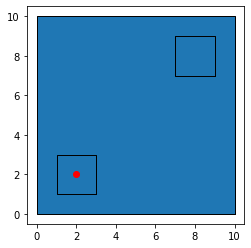

In [2]:
p1 = box(0,0,10,10)
p2 = box(1,1, 3,3)
p3 = box(7,7, 9,9)

gdf = geopandas.GeoDataFrame(geometry=[p1,p2,p3])
base = gdf.plot(edgecolor='k')

pnt1 = geopandas.GeoDataFrame(geometry=[Point(2,2)])
pnt1.plot(ax=base,color='red')

In [3]:
pnt1.within(gdf.geometry[0])

0    True
dtype: bool

In [4]:
pnt1.within(gdf.geometry[1])

0    True
dtype: bool

The violation here is that `pnt1` is `within` *both* polygon `p1` *and* `p2`.

## Error in area calculations

A related error that arises in this case is that the area of the "containing" polygon will be too large, since it includes the area of the smaller polygons:

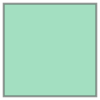

In [5]:
gdf.geometry[0]

In [6]:
gdf.area

0    100.0
1      4.0
2      4.0
dtype: float64

In [7]:
gdf.area.sum()

108.0

## Missing interior rings (aka holes)

The crux of the issue is that the two smaller polygons are entities in their own right, yet the large polygon was defined to have only a single external ring. It is missing two **interior rings**
which would allow for the correct topological relationship between the larger polygon and the two smaller polygons.

`geoplanar` can detect missing interiors:

In [8]:
mi = geoplanar.missing_interiors(gdf)
mi

[(0, 1), (0, 2)]

## Adding interior rings
Once we know that the problem is missing interior rings, we can correct this with `add_interiors`:

In [9]:
gdf1 = geoplanar.add_interiors(gdf)

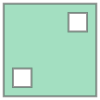

In [10]:
gdf1.geometry[0]

And we see that the resulting area of the GeoSeries is now correct:

In [11]:
gdf1.area

0    92.0
1     4.0
2     4.0
dtype: float64

Additionally, a check for `missing_interiors` reveals the violation has been corrected

In [12]:
geoplanar.missing_interiors(gdf1)

[]

The addition of the interior rings also corrects the violation of the containment rule that a point should belong to at most a single polygon in a planar enforced polygon geoseries:


In [13]:
pnt1.within(gdf1.geometry[0])

0    False
dtype: bool

In [14]:
pnt1.within(gdf1.geometry[1])

0    True
dtype: bool